# Tutorial 2: Similarity and Clustering

In this tutorial you are going to learn how to:

<div class="alert alert-block alert-warning">
    
**[Add fingerprints to the database](#Adding-fingerprints)**
    
**[Create new fingerprint classes](#Defining-new-fingerprints)**

**[Calculate similarity matrices](#Calculating-similarity-matrices)**
   
**[Perform clustering on similarity matrices](#Clustering)**
    
</div>

Let's get started!

In [1]:
import numpy as np

## Adding fingerprints

Material fingerprints can be used to compare materials. This is achieved by defining a fingerprint and similarity function and calculating all pairwise similarities between a set of materials. 

Frist, we are going to load the data from the first tutorial.

In [2]:
from simdatframe import MaterialsDatabase

In [3]:
db = MaterialsDatabase(filename="CuPdAu-energies.db")
assert len(db) == 196, "Please run tutorial 1 first!"

Next, we can add fingerprints. We start with exisiting implementations. Later you will see how to create your own fingerprints.

You can calculate fingerprints and add them to the database by using:

```python
MaterialsDatabase().add_fingerprint(<fingerprint_type>, name =  <name>)
```

Make sure to take a look at the documentation for a description of all parameters.

We will add the `PTE` fingerprint, as it was used in [this publication].

In [4]:
db.add_fingerprint("PTE", name = "PTE01")

2022-09-06 19:09:40,996 - CuPdAu-energies_log - INFO - Generating PTE01 fingerprints...


  0%|          | 0/196 [00:00<?, ?it/s]

2022-09-06 19:09:45,960 - CuPdAu-energies_log - INFO - Writing PTE01 fingerprints to database...
2022-09-06 19:09:50,055 - CuPdAu-energies_log - INFO - Finished generation of PTE01 fingerprints.


We can investigate which data is stored in the database by looking at the `properties` attribute of a `Material` from the database:

In [5]:
db[0].properties

{'energy_per_atom': -4.308142215, 'PTE': '{"averaged_PTE_column": 10.75}'}

The key used to store the data is the `name` attribute we gave to the fingerprint upon creation. Therefore, different fingerprints should not have the same names.

We can get all fingerprints from the database by using:

In [6]:
pte_fingerprints = db.get_fingerprints("PTE", name = "PTE")

  0%|          | 0/196 [00:00<?, ?it/s]

In [7]:
pte_fingerprints[0]

Fingerprint(PTE, mid = afgxVJIdT-rG_oycfzvFp2tUtr8T, name = PTE)

We can calculate the similarity between two materials by using a method of the `Fingerprint`:

In [8]:
pte_fingerprints[0].get_similarity(pte_fingerprints[1])

1.0

Thus, the similarities between all fingerprints can be calculated. However, if many materials should be compared, you can use the `SimilarityMatrix`. It allows for parallel calculation using Pythons `multiprocessing` features and offers convenient methods for analysis.

In [9]:
from simdatframe import SimilarityMatrix

The matrix can be calculated just by providing a list of fingerprints:

In [10]:
pte_simat = SimilarityMatrix().calculate(pte_fingerprints)

You can access the entries of the matrix by the index in the matrix:

In [11]:
pte_simat[1][:5] # first five entries of the second row of the matrix

array([1. , 1. , 1. , 0.8, 0.8])

or using the material id:

In [12]:
pte_simat[db[1].mid][:5] # first five entries of the second row of the matrix

array([1. , 1. , 1. , 0.8, 0.8])

We can plot the matrix using `matplotlib`:

In [13]:
import matplotlib.pyplot as plt

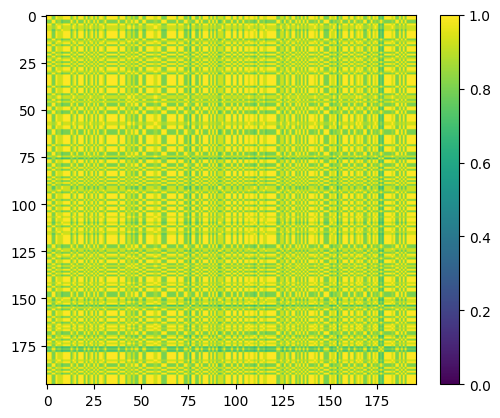

In [14]:
plt.imshow(pte_simat)
plt.clim(0,1)
plt.colorbar()
plt.show()

## Defining new fingerprints

Creation of new fingerprints can be achived by subclassing of the `Fingerprint` base class.

In this example, we will generate a fingerprint using the *S*mooth *O*verlap of *A*tomic *O*rbitals (SOAP) descriptor, as implemented in the `dscribe` package [reference here].

In [15]:
# We need the class to create the descriptor data
from dscribe.descriptors.soap import SOAP

In [16]:
# We also need the Fingerprint base class
from simdatframe import Fingerprint

First we need to make sure we understand how `dscribe` generates the descriptor. We start by creating a `SOAP` object:

In [17]:
soap = SOAP(r_cut=3, # cutoff radius: this property defines the length of interactions between ions
            n_max=2, # number of basis functions
            l_max=3, # highest order of spherical harmonics
            species=["Au", "Cu", "Pd"],  # (complete) set of species
            periodic=True, # periodicity of the input structures
            average="outer") # average local environments to obtain a global descriptor

We can check the output what kind of data is created by using:

In [18]:
soap.create(db[0].atoms)

array([ 2.72937079e+00, -1.25233156e+01,  6.99137110e+01,  1.56362817e-32,
       -6.16329608e-32,  2.48823001e-31,  8.21516084e-03, -4.34646138e-02,
        2.29961751e-01,  3.45216638e-02, -2.04984649e-01,  1.21716921e+00,
        1.27145387e+00, -6.89278976e+00, -6.89278976e+00,  3.06843999e+01,
        1.37214710e-33, -7.78815911e-33, -5.90321429e-33,  3.28108473e-32,
       -4.10757965e-03,  2.17323062e-02,  2.17323062e-02, -1.14980875e-01,
       -1.72608319e-02,  1.02492324e-01,  1.02492324e-01, -6.08584604e-01,
        1.27145387e+00, -6.89278976e+00, -6.89278976e+00,  3.06843999e+01,
        1.16451126e-33, -4.75528070e-33, -6.13580454e-33,  2.13540000e-32,
       -4.10757965e-03,  2.17323062e-02,  2.17323062e-02, -1.14980875e-01,
       -1.72608319e-02,  1.02492324e-01,  1.02492324e-01, -6.08584604e-01,
        7.23239503e-01, -2.82864203e+00,  1.97320878e+01,  1.10838267e-33,
       -5.00990379e-33,  2.37671674e-32,  2.07281795e-02, -1.05665784e-01,
        5.38842164e-01,  

As you can see, the descriptor consists of a list of floats, which can be stored easily.

In the following you see an example of how this descriptor can be implemented as a `Fingerprint`.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# First we define how the similarity between two fingerprints can be calculated.
# Here, we use the cosine similarity between two SOAP vectors as a metric.
# To ensure numerical stability, the result is rounded by 12 digits.
def SOAP_similarity(fp1, fp2):
    return np.round(cosine_similarity([fp1.data["coef"]], [fp2.data["coef"]])[0][0], 12)

# Define a new Fingerprint class
class SOAPFingerprint(Fingerprint):

    # We need to pass the `SOAP` object to the fingerprint. 
    # Thus we define the `__init__` method of the class.
    def __init__(self,
                 name=None,
                 similarity_function=SOAP_similarity,  
                 pass_on_exceptions=True,
                 creator=None) -> None:
        # Set the default values of the fingerprint
        super().__init__(fp_type = "SOAP",
                         name = name, 
                         similarity_function=similarity_function, 
                         pass_on_exceptions=pass_on_exceptions)
        # The SOAP object will be called `creator`
        self.creator = creator

    # Every fingerprint needs a `calculate` method.
    # It is used to derive the descriptor values from a `Material` object
    def calculate(self, material):
        # Upon calculation, we need to set the material id
        self.set_mid(material)
        # Next, calculate the descriptor data
        coef = self.creator.create(material.atoms)
        # Store the data in the fingerprint to be retrieved later
        self.set_data("coef", coef.tolist())
        return self

In [20]:
test_fp = SOAPFingerprint(creator=soap).calculate(db[0])

In [21]:
test_fp.fp_type

'SOAP'

In [22]:
test_fp.get_similarity(test_fp)

1.0

In [23]:
db.add_fingerprint(SOAPFingerprint, name="SOAP01", fingerprint_kwargs={"creator" : soap})

2022-09-06 19:09:59,194 - CuPdAu-energies_log - INFO - Generating SOAP01 fingerprints...


  0%|          | 0/196 [00:00<?, ?it/s]

2022-09-06 19:10:03,724 - CuPdAu-energies_log - INFO - Writing SOAP01 fingerprints to database...
2022-09-06 19:10:08,136 - CuPdAu-energies_log - INFO - Finished generation of SOAP01 fingerprints.


In [24]:
db[0].properties

{'energy_per_atom': -4.308142215,
 'PTE': '{"averaged_PTE_column": 10.75}',
 'SOAP01': '{"mid": "afgxVJIdT-rG_oycfzvFp2tUtr8T", "name": "SOAP01", "fp_type": "SOAPFingerprint", "data": "{\\"coef\\": [2.729370787448099, -12.523315593865936, 69.91371097235547, 1.563628173247292e-32, -6.163296081796848e-32, 2.4882300116614184e-31, 0.008215160844797268, -0.043464613845929596, 0.22996175126146395, 0.03452166381125832, -0.20498464862937288, 1.2171692072386207, 1.2714538673610294, -6.892789759440248, -6.892789759440248, 30.68439991629572, 1.3721470950580723e-33, -7.788159111287412e-33, -5.9032142926844386e-33, 3.28108472879093e-32, -0.004107579648074642, 0.02173230616101092, 0.021732306161010916, -0.11498087488095061, -0.01726083190562916, 0.10249232431468645, 0.10249232431468645, -0.6085846036193103, 1.2714538673610294, -6.892789759440249, -6.892789759440249, 30.684399916295718, 1.1645112642691154e-33, -4.7552806994983604e-33, -6.135804544385532e-33, 2.1354000038358298e-32, -0.004107579648074

Next, we read the new fingerprints from the database. Since this time we created a custom fingerprint class, we need to provide the similarity function when deserializing the data.

In [25]:
fps = db.get_fingerprints(SOAPFingerprint, # This is our fingerprint class 
                          name="SOAP01", # Make sure the name matches the name that was used upon creation
                          similarity_function=SOAP_similarity) # Here we provide the similarity function

  0%|          | 0/196 [00:00<?, ?it/s]

Calculate and plot the matrix:

In [26]:
soap_simat = SimilarityMatrix().calculate(fps)

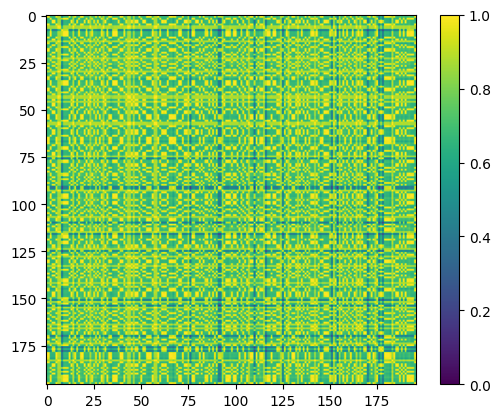

In [27]:
plt.imshow(soap_simat)
plt.clim(0,1)
plt.colorbar()
plt.show()

This matrix looks interesting, but since the entries are sorted by the order in which they where added to the database, it is hard to see any meaningful relationships in it. We can change this by clustering the matrix and sorting the materials according to their cluster label.

First, let's import the required class:

In [28]:
from simdatframe.clustering import SimilarityMatrixClusterer

We start by creating a clusterer object:

In [29]:
clus = SimilarityMatrixClusterer(soap_simat, # This is the matrix we want to cluster
                                 # The `clusterer_kwargs`  are passed to the `clusterer` object,
                                 # which is `sklearn.clustering.DBSCAN` by default.
                                 # Since we cluster based on an existing similarty matrix, it is
                                 # important to set 'metric' to 'precomputed'. 
                                 clusterer_kwargs= {'metric': 'precomputed',
                                                    # The 'eps' parameter defines a threshold for clustering
                                                    # Since DBSCAN works with distances, the threshold is
                                                    # to be understood as (1 - similarity)
                                                    'eps': 0.01,
                                                    # 'min_samples' defines the minimum cluster size
                                                    #finally we call the `cluster` method
                                                    'min_samples' : 2 }).cluster() 

In [30]:
print(f"We found {clus.nclusters} clusters")

We found 7 clusters


We obtain the sorted matrix from the clusterer:

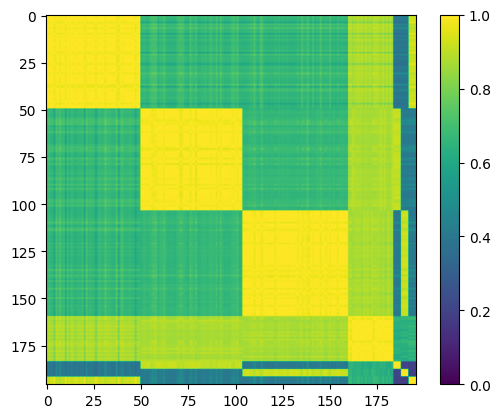

In [31]:
plt.imshow(clus.get_sorted_similarity_matrix())
plt.clim(0,1)
plt.colorbar()
plt.show()

In the sorted matrix we can clearly identify the seven distinct clusters.

In the next step, we will additionally generate space group (SG) and periodic-table-of-elements (PTE) fingerprints and compare the similarity matrices.

In [32]:
# First, we obtain the ids of the materials sorted by the clustering
sorted_mids = clus.get_mids_sorted_by_cluster_labels()
# Get SG fingerprints with default settings
sg_fps = db.get_fingerprints("SG")
# Calculate the matrix and sort it according to the clustering
sg_simat = SimilarityMatrix().calculate(sg_fps).get_sub_matrix(sorted_mids, copy = False)

  0%|          | 0/196 [00:00<?, ?it/s]

We repeat the steps for the PTE descriptor:

In [33]:
# Get PTE fingerprints with default settings
PTE_fps = db.get_fingerprints("PTE")
# Calculate the matrix, and sort the results according to the clustering
PTE_simat = SimilarityMatrix().calculate(PTE_fps).get_sub_matrix(sorted_mids, copy = False)

  0%|          | 0/196 [00:00<?, ?it/s]

In [34]:
# assert that the entries of the matrices are sorted in the same way
assert all(sg_simat.mids == PTE_simat.mids), "Matrices are not sorted in the same way."

We can now plot all three matrices side by side:

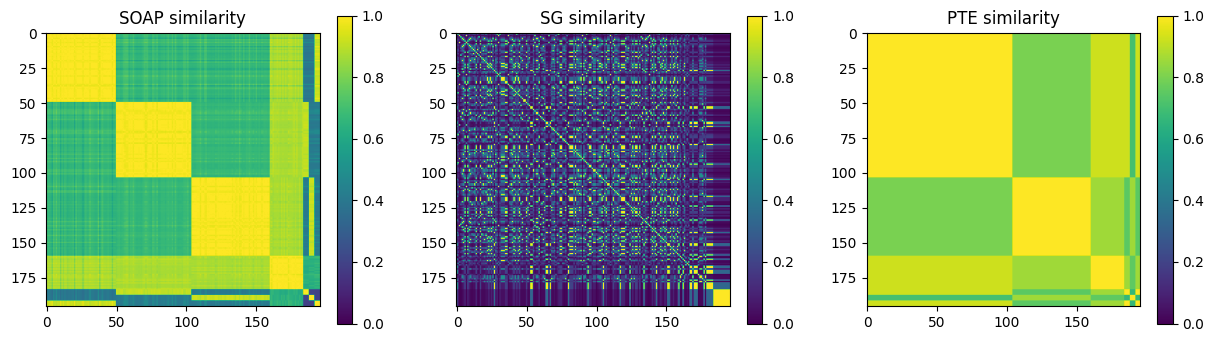

In [35]:
fig = plt.figure(figsize = (15,4))
fig.add_subplot(1,3,1)
plt.imshow(clus.get_sorted_similarity_matrix())
plt.clim(0,1)
plt.colorbar()
plt.title("SOAP similarity")
fig.add_subplot(1,3,2)
plt.imshow(sg_simat)
plt.clim(0,1)
plt.colorbar()
plt.title("SG similarity")
fig.add_subplot(1,3,3)
plt.imshow(PTE_simat)
plt.clim(0,1)
plt.colorbar()
plt.title("PTE similarity")
plt.show()

The meaning of the SOAP similarity is [covered elsewhere](https://doi.org/10.1039/C6CP00415F). The SG similarity is defined as the intersection divided by the union of symmetry operations that are between two crystal lattices. The PTE similarity is compares the average of the column of the periodic table of elements over all atoms in a unit cell. Thus, it is related to the composition of the materials, but agnostic to the crystal structure.

Comparing all three matrices visually unveils that the majority of the clusters that are found with the SOAP descriptor are also visible in the PTE similarity. Importantly, the two large clusters in the SOAP matrix are not distinct when using the PTE descriptor. The symmetry operations, as analyzed by the SG similarity, appear to play a minor role. However, the small clusters at index $\sim 50$ and at the right bottom corner of the matrices appear also there.

Next, we compare these matrices to a matrix generated from the energy per atom of the materials.

In [36]:
prop_fingerprints = db.get_fingerprints("PROP", name = "PROPepa", fingerprint_kwargs={"property_path" : "energy_per_atom", "from_data" : False})

  0%|          | 0/196 [00:00<?, ?it/s]

In [37]:
epa_simat = SimilarityMatrix().calculate(prop_fingerprints).get_sub_matrix(sorted_mids)

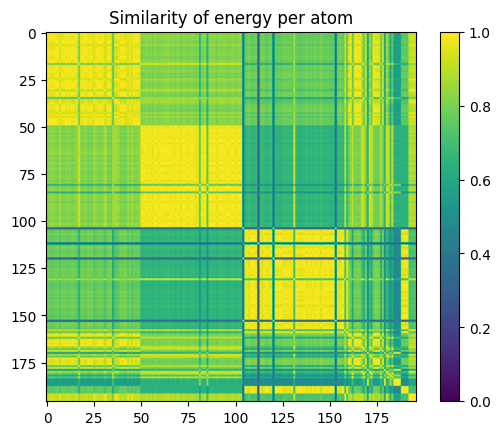

In [38]:
plt.figure()
plt.imshow(epa_simat)
plt.clim(0,1)
plt.colorbar()
plt.title("Similarity of energy per atom")
plt.show()

When comparing this matrix to the matrices generated by the descriptors above, we can see that the SOAP and PTE matrices show very similar structure to the matrix generated by the energy per atom. Thus, we can conclude that these properties correlate with the descriptors. Moreover, the largest influence to the differences between energy of formation appears to be driven by the differences in chemical composition, as is is reflected by the PTE descriptor. The atomic density, which, additionally, is represented by the SOAP descriptor, appears to be more important for the substructure within the larger clusters.

However, we note that non of the descriptors is a direct measure of the energy per atom, which is indicated by the dark and bright lines in the property similarity matrix - these elements should have similar properties according to the SOAP fingerprint, but, their energies per atom are different.

In the next tutorial, we will use those matrices to build supervised machine learning models, predicting the energy per atom. For this purpose, we can save the similarity matrices, and load them in the next tutorial.

In [39]:
soap_simat.save('CuPdAu_SOAP_simat.npy', "data")
PTE_simat.save('CuPdAu_PTE_simat.npy', "data")
sg_simat.save('CuPdAu_SG_simat.npy', "data")